# Predict Survival from Measured Concentrations

This notebook predicts bacterial survival probabilities from fitted concentration profiles by:
1. Loads HQNO and RHL concentration fit parameters
2. Loads survival model parameters from batch survival experiments
3. Calculates survival probabilities using logistic regression models fitted to exaustive sampling of experimental fit parameters

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import sys
sys.path.append(str(Path.cwd().parent / '0_plot_functions'))
from plot_publication_figures import plot_dual_axis_percentiles

def uptake_diffusion_sinh(x, c_max, L, A):
    """
    Calculates numerically stable uptake–diffusion concentration profile, assuming zero boundary condition at x=L.

    Parameters:
    - x: array-like, positions along the gradient
    - c_max: float, maximum concentration at x=0
    - L: float, length of the domain
    - A: float, uptake/diffusion rate [1/m^2]

    Returns:
    - c: array-like, concentration at positions x
    c(x) = c_max * sinh(sqrt(A)*(L - x)) / sinh(sqrt(A)*L)

    """
    sA = np.sqrt(A)
    return c_max * np.sinh(sA * (L - x)) / np.sinh(sA * L)

def inv_logit(z):
    z = np.asarray(z, dtype=float)
    return 1.0 / (1.0 + np.exp(-z))

def predict_survival(conc_h, conc_r, model_params):
    """
    Predict survival probability given concentration and model parameters.
    
    Parameters:
    - conc_h: array-like, concentrations of hqno
    - conc_r: array-like, concentrations of rhl
    - model_params: dict, parameters of the logistic regression model with keys 'm_rhl', 'm_hqno', and 'b'
    
    Returns:`
    - survival_probs: array-like, predicted survival probabilities
    """

    m_rhl  = float(model_params["m_rhl"])
    m_hqno = float(model_params["m_hqno"])
    b      = float(model_params["b"])

    rz = m_rhl  * conc_r  + m_hqno * conc_h + b
    survival_probs = inv_logit(rz)
    
    return survival_probs

def create_concentration_profile(df, x_vals):
    """
    Generate concentration profiles for all replicates at specified x positions.
    
    Parameters:
    - df: DataFrame containing fit parameters (c_max, L, A) and unique_id
    - x_vals: array-like, positions along the gradient where concentrations are calculated
    
    Returns:
    - conc_profiles: DataFrame with columns 'unique_id', 'x', and 'concentration'
    """
    conc_profiles_list = []
    for _, row in df.iterrows():
        unique_id = row['unique_id']
        c_max = row['c_max']
        L = row['L']
        A = row['A']
        c_x = uptake_diffusion_sinh(x_vals, c_max, L, A)
        conc_profile = {
            'unique_id': unique_id,
            'y_um': x_vals,
            'concentration': c_x,
        }
        conc_profiles_list.append(conc_profile)

    conc_profiles = pd.DataFrame(conc_profiles_list).explode(['y_um', 'concentration']).reset_index(drop=True)
    return conc_profiles

units of measured parameters: {'Rhamnolipids': 'µg/ml', 'HQNO': 'ng/ml'}
units of measured parameters: {'Rhamnolipids': 'µg/ml', 'HQNO': 'ng/ml'}
units of measured parameters: {'Rhamnolipids': 'µg/ml', 'HQNO': 'ng/ml'}


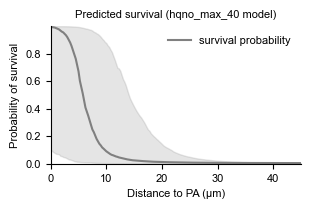

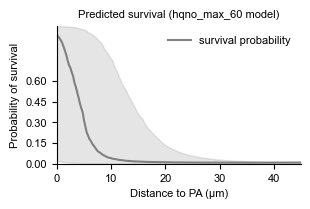

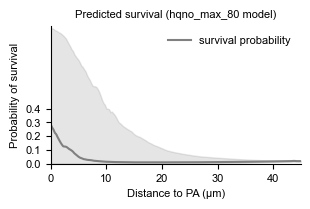

In [12]:
# Paths to data files
HQNO_CSV = Path.cwd().parent / '2_gradient_inference' / 'data' / '2_hqno_diffusion_model_fits.csv'
RHL_CSV = Path.cwd().parent / '2_gradient_inference' / 'data' / '2_rhl_diffusion_model_fits.csv'
SURVIVAL_JSON = Path.cwd().parent / '3_batch_survival' / 'data' / 'survival_model_parameters.json'

# ——— figure style ———
final_width_cm = 8    # width in cm
final_height_cm = 5   # height in cm
final_width_in = final_width_cm / 2.54
final_height_in = final_height_cm / 2.54
font_size = 8  # points
plt.rcParams.update({
    'font.size': font_size,
    'font.family': 'Arial',
    'axes.labelsize': font_size,
    'axes.titlesize': font_size,
    'xtick.labelsize': font_size,
    'ytick.labelsize': font_size,
    'legend.fontsize': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# HQNO color (green)
hqno_color = '#669966'

# RHL color (purple)
rhl_color = '#cc99ff'

# --- Load data ---
df_hqno_fit = pd.read_csv(HQNO_CSV)
df_rhl_fit = pd.read_csv(RHL_CSV)

# Create unique IDs
df_hqno_fit['unique_id'] = df_hqno_fit['replicate'].astype(str) + '_' + df_hqno_fit['pos'].astype(str)
df_rhl_fit['unique_id'] = df_rhl_fit['replicate'].astype(str) + '_' + df_rhl_fit['pos'].astype(str)

# Load linear params
with open(SURVIVAL_JSON, "r", encoding="utf-8") as f:
    cfg = json.load(f)

survival_models = cfg.keys()

# Generate high-resolution fitted curves for plotting
y_fit = np.linspace(0, 45, 181)
df_hqno = create_concentration_profile(df_hqno_fit, y_fit)
df_rhl = create_concentration_profile(df_rhl_fit, y_fit)


# --- Predict survival probabilities directly from measured concentrations ---

n_rep_h = len(df_hqno['unique_id'].unique())
n_rep_r = len(df_rhl['unique_id'].unique())
pred_survival = []

y_axis = {'hqno_max_40': (1, np.linspace(0, 0.8, 5)),
          'hqno_max_60': (1, np.linspace(0, 0.6, 5)),
          'hqno_max_80': (1, np.linspace(0, 0.4, 5))}

for model in survival_models:
    print('units of measured parameters:', cfg[model]['units'])

    # Calculate survival probabilities using empirical sampling of concentration profiles to estimate variability
    for i in range(n_rep_h):
        for j in range(n_rep_r):
            conc_hqno = df_hqno[df_hqno['unique_id'] == df_hqno['unique_id'].unique()[i]][ 'concentration'].values
            conc_rhl = df_rhl[df_rhl['unique_id'] == df_rhl['unique_id'].unique()[j]][ 'concentration'].values

            y_hqno = df_hqno[df_hqno['unique_id'] == df_hqno['unique_id'].unique()[i]][ 'y_um'].values
            y_rhl = df_rhl[df_rhl['unique_id'] == df_rhl['unique_id'].unique()[j]][ 'y_um'].values

            if not np.array_equal(y_hqno, y_rhl) or len(y_hqno) == 0 or len(y_rhl) == 0:
                raise ValueError('y positions of hqno and rhl do not match!')

            survival_prob = predict_survival(conc_hqno, conc_rhl, cfg[model]['parameters'])

            output = {
                'model': model,
                'hqno_id': df_hqno['unique_id'].unique()[i],
                'rhl_id': df_rhl['unique_id'].unique()[j],
                'unique_id': f"{df_hqno['unique_id'].unique()[i]}_{df_rhl['unique_id'].unique()[j]}",
                'y_um': y_hqno,
                'conc_hqno': conc_hqno,
                'conc_rhl': conc_rhl,
                'predicted_survival': survival_prob
            }

            pred_survival.append(output)

df_pred_survival = pd.DataFrame(pred_survival).explode(['y_um', 'conc_hqno', 'conc_rhl', 'predicted_survival'])

for model in survival_models:
    loc_df = df_pred_survival[df_pred_survival['model'] == model]

    # --- Plot measured concentration gradients ---
    left_data = [{
        'df': loc_df,
        'y_col': 'predicted_survival',
        'label': 'survival probability',
        'color': 'grey',
        'ylabel': 'Probability of survival',
        'ylim': (0, y_axis[model][0]),
        'yticks': y_axis[model][1]
    }]


    x_config = {
        'xlabel': "Distance to PA (µm)",
        'xlim': (0, 45)
    }

    fig, ax = plot_dual_axis_percentiles(left_axis_data=left_data, 
                                         x_col='y_um', x_config=x_config, 
                                         percentiles=[25, 50, 75],   
                                           figsize=(final_width_in, final_height_in),
                                           font_size=font_size)

    ax.set_title(f'Predicted survival ({model} model)', fontsize=font_size)

    # Show outputs
    plt.show()

Given low measured concentration range of HQNO, we proceed with model fitted in lowest range

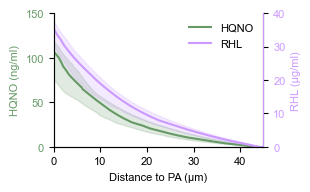

[info] Plotted HQNO (left axis) and RHL (right axis) with percentile bands


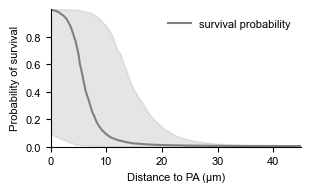

[info] Plotted predicted survival (hqno_max_40 model) with percentile bands


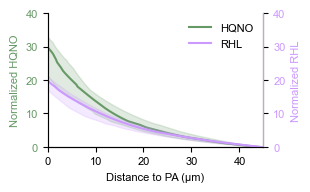

[info] Plotted HQNO (left axis) and RHL (right axis) with percentile bands


In [13]:
model = 'hqno_max_40'  # Given low measured concentration range of HQNO, we proceed with model fitted in lowest range

# --- Plot measured concentration gradients ---
left_data = [{
    'df': df_hqno,
    'y_col': 'concentration',
    'label': 'HQNO',
    'color': hqno_color,
    'ylabel': 'HQNO (ng/ml)',
    'ylim': (0, 150),
    'yticks': np.linspace(0, 150, 4)
}]

right_data = [{
    'df': df_rhl,
    'y_col': 'concentration',
    'label': 'RHL',
    'color': rhl_color,
    'ylabel': 'RHL (µg/ml)',
    'ylim': (0, 40)
}]

x_config = {
    'xlabel': "Distance to PA (µm)",
    'xlim': (0, 45)
}

fig, ax = plot_dual_axis_percentiles(
    left_axis_data=left_data,
    right_axis_data=right_data,
    x_col='y_um',
    x_config=x_config,
    percentiles=[25, 50, 75],
    figsize=(final_width_in, final_height_in),
    font_size=font_size
)

# Save outputs
plt.savefig(f'./figures/3_fitted_concentrations.pdf', dpi=300, transparent=True)
plt.show()

print(f"[info] Plotted HQNO (left axis) and RHL (right axis) with percentile bands")


# --- plot predicted survival from conc ---
df_pred = df_pred_survival[df_pred_survival['model'] == model]

# --- Plot measured concentration gradients ---
left_data = [{
    'df': df_pred,
    'y_col': 'predicted_survival',
    'label': 'survival probability',
    'color': 'grey',
    'ylabel': 'Probability of survival',
    'ylim': (0, y_axis[model][0]),
    'yticks': y_axis[model][1]
}]


x_config = {
    'xlabel': "Distance to PA (µm)",
    'xlim': (0, 45)
}

fig, ax = plot_dual_axis_percentiles(left_axis_data=left_data, 
                                        x_col='y_um', x_config=x_config, 
                                        percentiles=[25, 50, 75],   
                                        figsize=(final_width_in, final_height_in),
                                        font_size=font_size)


# Save outputs
plt.savefig(f'./figures/3_predicted_survival_from_fit.pdf', dpi=300, transparent=True)
plt.show()

print(f"[info] Plotted predicted survival ({model} model) with percentile bands")

# --- Plot measured concentration gradients, rescaled with logit model parameters ---

df_hqno['scaled_conc'] = (cfg[model]['parameters']['m_hqno'] * df_hqno['concentration'])
df_rhl['scaled_conc'] = np.abs(cfg[model]['parameters']['m_rhl']) * df_rhl['concentration']



left_data = [{
    'df': df_hqno,
    'y_col': 'scaled_conc',
    'label': 'HQNO',
    'color': hqno_color,
    'ylabel': 'Normalized HQNO',
    'ylim': (0, 40),
    'yticks': np.linspace(0, 40, 5)
}]

right_data = [{
    'df': df_rhl,
    'y_col': 'scaled_conc',
    'label': 'RHL',
    'color': rhl_color,
    'ylabel': 'Normalized RHL',
    'ylim': (0, 40),
    'yticks': np.linspace(0, 40, 5)
}]

x_config = {
    'xlabel': "Distance to PA (µm)",
    'xlim': (0, 45)
}

fig, ax = plot_dual_axis_percentiles(
    left_axis_data=left_data,
    right_axis_data=right_data,
    x_col='y_um',
    x_config=x_config,
    percentiles=[25, 50, 75],
    figsize=(final_width_in, final_height_in),
    font_size=font_size
)

# Save outputs
plt.savefig(f'./figures/3_fitted_normalized_concentrations.pdf', dpi=300, transparent=True)
plt.show()

print(f"[info] Plotted HQNO (left axis) and RHL (right axis) with percentile bands")


